# Practice: First, Hydro-dynamical PDE models

In [1]:
# Importing relevant libraries 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
from nm_lib import nm_lib as nm
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# plt.style.use('dark_background')
plt.style.use('default')

As modelers of stellar atmospheres, we are primarily interested in solving the equations of mass, momentum, and energy balance, along with the equations governing the evolution of the magnetic field, the transport equations for the radiation field, heat flux equations, etc. For this project, we will start with the hydrodynamic equations in 1 dimension as follows: 

$$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = 0 $$

$$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u} \otimes {\bf u}) = - \nabla (P_g)$$

$$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u}$$

where $\rho$, $\bf u$, $P_g$, and $e$ are the density, velocity vector, gas pressure, and internal energy. $\cdot$ and $\otimes$ are the dyadic and tensorial product, respectively. One extra equation needs to connect the pressure with the energy. For this you can use $P_g  = (\gamma-1)e/\rho$ where $\gamma=5/3$. Note that, in 1 dimension the operation  $\nabla \cdot (\rho {\bf u} \otimes {\bf u})$ becomes as follows: 

$$ \nabla \cdot (\rho {\bf u} \otimes {\bf u}) = \frac{\partial (\rho u^2)}{\partial x} $$

<span style="color:pink">

We begin by writing a code for the hydro-dynamical PDE models. 

In 1D, the RHS of the continuity equation can be written as 

$$
\frac{\partial\rho}{\partial t} + \frac{\partial\rho u}{\partial x} \rightarrow \frac{\partial\rho}{\partial t} = -\frac{\partial\rho u}{\partial x}
$$

Similarely for the momentum equation, 

$$
\frac{\partial\rho u}{\partial t} = -\frac{\partial\rho u^2}{\partial x} - \frac{\partial P g}{\partial x}, 
$$

and for the energy equation we have 

$$
\frac{\partial e}{\partial t} = -\frac{\partial eu}{\partial x} - P_g\frac{\partial u}{\partial x}. 
$$

This means that the fluxes can be written as $F_\rho = \rho u$, $F_v = \rho u^2 + P_g$, and $F_e = u(e + P_g)$. 

These are implemented in `step_density`, `step_momentum` and `step_energy`. 

Next, we evolve the equations in time in `evolv_hydro`. 

The pressure, $P_g = (\gamma - 1 )e\rho$ is the extra energy-pressure relation where $\gamma = 5/3$, and $u = p/\rho$, where $p$ is the momentum. 

</span>

In [2]:
# def drho_dt(uu, xx, rho): 
#     ddx_rho = nm.deriv_upw()

def deriv_cent(xx, hh, **kwargs):
    r"""
    returns the centered 2nd derivative of hh respect to xx. 

    Parameters
    ---------- 
    xx : `array`
        Spatial axis. 
    hh : `array`
        Function that depends on xx. 

    Returns
    -------
    `array`
        The centered 2nd order derivative of hh respect to xx. First 
        and last grid points are ill calculated. 
    """
    
    if kwargs['axis']: 
        return (np.roll(hh, -1, axis=kwargs['axis']) - np.roll(hh, 1, axis=kwargs['axis'])) \
            / (np.roll(xx, -1, axis=kwargs['axis']) - np.roll(xx, 1, axis=kwargs['axis']))
    else:
        return (np.roll(hh, -1) - np.roll(hh, 1)) / (np.roll(xx, -1) - np.roll(xx, 1))


def step_density(xx, rho, u, axis=0, cfl_cut=0.98, ddx=lambda x, y: nm.deriv_cent(x, y), bnd_limits=[1,1]): 
    """ 
    Right hand side of the 1D continuity equation, where rho can be a constant or a function of xx. 
    """
    dx = xx[1] - xx[0]
    a = rho*u
    dt = cfl_cut*np.min(dx/np.abs(a))

    return dt, -ddx(xx, a, axis=axis)

def step_momentum(xx, rho, u, Pg, axis=0, cfl_cut=0.98, ddx=lambda x, y: nm.deriv_cent(x, y), bnd_limits=[1,1]): 
    """ 
    Right hand side of the 1D momentm equation, where Pg can be a constant or a function of xx. 
    """
    dx = xx[1] - xx[0]
    a = rho*u**2 + Pg
    dt = cfl_cut*np.min(dx/np.abs(a))

    return dt, -ddx(xx, a, axis=axis)

def step_energy(xx, e, u, Pg, axis=0, cfl_cut=0.98, ddx=lambda x, y: nm.deriv_cent(x, y), bnd_limits=[1,1]):
    """ 
    Right hand side of the 1D energy equation, where rho can be a constant or a function of xx. 
    """
    dx = xx[1] - xx[0]
    a = u*(e + Pg)
    dt = cfl_cut*np.min(dx/np.abs(a))

    return dt, -ddx(xx, a, axis=axis)

<span style="color:pink">

The time step is important when solving these computational Hydro-Dynamical PDE models. We need to find a balance between computational performance and realistic dynamics, and this is often dependend on the time-step. 

All simulations make assumptions that are impacted by time-step and other factors, such as the solver and mesh cell density. 

The time-step depends on a variety of factors, from mesh cell size, velocity magnitude, solvers and iterations used. 
Additionally, the time-step may be limited due to the computational resources available with a lack of computational processing unit (CPU) power or lack of memory (RAM) for mesh modelling. 

Typically, a large time-step can lead to unstable assumptions and solutions at each step of the solution. The assumptions do not model the flow dynamics correctly and may lead to exponential maximum velocity before the solution fails due to pressure and velocity overload. 

One method for calculating the maximum time-step is the Courant-Friedrichs-Lewy (CFL) condition, 

$$
C = a\frac{\Delta t}{\Delta x}
$$

The CFL condition uses a Courant number, C, calculated from the maximum velocity, a, time-step, $\Delta t$, and the minimum distance between mesh cells, $\Delta x$. The Courant number is a dimensionless number which is a measure of a solution being solved within a mesh cell. Ideally, solutions are solved for each cell avoiding assumptions over multiple mesh cells which can lead to instabilities. The CFL condition is re-arranged to calculate the maximum time-step. A Courant number of 1 will be the maximum theoretical time-step for simulating a stable solution as it is the smallest distance between mesh cells. A Courant number of 0.5 is recommended for an initial guess for a stable solution where it is smaller than the smallest mesh cell-size distance. This should ensure velocity vectors do not exceed several mesh cells and lead to large assumptions and an unstable simulation. 


In this case, the CFL condition is dependent on the 

CFL condition 

sound speed (gamma, pg rho)

We no longer just have `a`, but rather u (osmething plus and minus?)
u+ and - c 

For the timestep, we need to compare all three dt's to get the lowest timestep (`np.min([dt1, dt2, dt3])`). 

I will write one solved using Euler, and another using Lax (with an average of 3). #np roll -1, regular, +1 

xxx talk about the order. 

For Euler, 

$$
f^t(x) = \frac{\partial F(t,x)}{\partial t} = \frac{F(x, t+\Delta t) - F(x, t)}{\Delta t} + \Order (\Delta t^2)
$$

while for Lax, 

xxx 

</span>

## 1- Build or select your code 

In this exercise, you can select one of the following options: 

1. Build your hydro-dynamical (HD) numerical code applying the tools/functions learned during the 6th different assessment. Solve the above set of equations in one dimension. 

    __A plus__ implement the [Bifrost 6th order spatial derivative, 5th order spatial interpolation](https://github.com/AST-Course/AST5110/wiki/Discretization) with the hyper-diffusion scheme (see [wiki](https://github.com/AST-Course/AST5110/wiki/Hyper-diffusive)). Note that Bifrost is using a [staggered mesh](https://github.com/AST-Course/AST5110/wiki/Staggered-mesh) where the density, pressure, energy, and temperature are cell-centered, and velocity and momentum are at the edges (in 1 dimension). 

    __A plus__ implement the [Flux limiter method](https://github.com/AST-Course/AST5110/wiki/Flux-limiter-method).

    __A plus__ implement the [Rieman Solver method](https://github.com/AST-Course/AST5110/wiki/Rieman-Solver-method).

    What would you choose for the CFL condition? 

2. Use the Bifrost, Ebysus, or other numerical codes you are interested in learning. 

    Note that I can help only with the numerical codes that I'm familiar with, but you should still select the ones you are interested in as long as you have access to them. 

    Johannes: Since you do this excersize with an existing code. You will need to investigate, spatial derivative order and temporal orders. Fully test with Riemann solvers. As well as investigate the k-diagrams for a test that has initial random perturbations in density/velocity. 

In [88]:
def evol_hydro_euler(xx, rho, u, e, Pg, nt, gamma=1.4, axis=0, cfl_cut=0.98, 
                    ddx=lambda x,y: nm.deriv_cent(x, y), bnd_type='wrap', bnd_limits=[1,0], **kwargs):
    """ 
    Evolution of the hydrodynamic equations in time using the Euler method. 

    Parameters
    ----------
    xx : `array`
        Spatial axis.
    rho : `array`
        Density.
    u : `array`
        Velocity.
    e : `array`
        Energy.
    Pg : `array`
        Gas pressure.
    nt : `int`
        Number of time steps.
    axis : `int`
        Axis to be used in the derivative.
    cfl_cut : `float`
        Constant value to limit dt from cfl_adv_burger. 
        By default 0.98
    ddx : `lambda function` 
        Allows to change the space derivative function. 
        By default lambda x,y: deriv_cent(x, y)
    bnd_type : `string` 
        Allows to select the type of boundaries
        by default 'wrap'
    bnd_limits : `list(int)`
        List of two integer elements. The number of pixels that
        will need to be updated with the boundary information. 
        By defalt [1,0]
    
    Returns
    -------
    """
    
    # Initialize the arrays
    t = np.zeros((nt))
    rho_arr = np.zeros((len(xx), nt))
    mom_arr = np.zeros((len(xx), nt))
    e_arr   = np.zeros((len(xx), nt))
    
    # Set the initial conditions
    rho_arr[:,0] = rho
    mom_arr[:,0] = rho*u
    e_arr[:,0] = e

    # Calculate the smallest step size
    dx = xx[0] - xx[1]
    # dt_cfl = cfl_cut*np.min(dx/np.abs(u))

    for i in range(nt-1): 
        dt1, rhs_cont = step_density( xx, rho_arr[:,i], u,        axis=axis, cfl_cut=cfl_cut, ddx=ddx, bnd_limits=bnd_limits)
        dt2, rhs_mom  = step_momentum(xx, mom_arr[:,i], u, Pg=Pg, axis=axis, cfl_cut=cfl_cut, ddx=ddx, bnd_limits=bnd_limits)
        dt3, rhs_e    = step_energy(  xx,   e_arr[:,i], u, Pg=Pg, axis=axis, cfl_cut=cfl_cut, ddx=ddx, bnd_limits=bnd_limits)

        # Calculate the smallest time step
        # dt = cfl_cut*min(np.diff(xx))/np.max(np.abs(u)) # Add all the velocities?
        dt = cfl_cut*np.min([dt1, dt2, dt3])

        # Evolve in time (Euler)
        # rho_temp = rho_arr[:,i] + rhs_cont*dt
        # mom_temp = mom_arr[:,i] + rhs_mom*dt
        # e_temp   = e_arr[:,i]   + rhs_e*dt

        # LAX
        rho_temp = (1/3)*(np.roll(rho_arr[:,i], -1) + np.roll(rho_arr[:,i], 1)) + rhs_cont*dt
        mom_temp = (1/3)*(np.roll(mom_arr[:,i], -1) + np.roll(mom_arr[:,i], 1)) + rhs_mom*dt
        e_temp   = (1/3)*(np.roll(  e_arr[:,i], -1) + np.roll(  e_arr[:,i], 1)) + rhs_e*dt

        #  Set the boundaries 
        if bnd_limits[1] > 0: 
            # downwind and central
            rho_temp1 = rho_temp[bnd_limits[0]:-bnd_limits[1]] 
            mom_temp1 = mom_temp[bnd_limits[0]:-bnd_limits[1]] 
            e_temp1   =   e_temp[bnd_limits[0]:-bnd_limits[1]] 
        else: 
            # upwind
            rho_temp1 = rho_temp[bnd_limits[0]:]
            mom_temp1 = mom_temp[bnd_limits[0]:]
            e_temp1   =   e_temp[bnd_limits[0]:]

        ## Updates in time 
        rho_arr[:, i+1] = np.pad(rho_temp1, bnd_limits, bnd_type)
        mom_arr[:, i+1] = np.pad(mom_temp1, bnd_limits, bnd_type)
        e_arr[:, i+1]   = np.pad(e_temp1,   bnd_limits, bnd_type)
        t[i+1]          = t[i] + dt 

        # Update u and Pg 
        u = mom_arr[:,i+1] / rho_arr[:,i+1]
        Pg = (gamma-1)*e_arr[:,i+1]*rho_arr[:,i+1]
    
    return t, rho_arr, mom_arr, e_arr

<span style="color:pink">

Implementing the Bifrost 6th order spatial derivative, 5th order spatial interpolation with the hyerdiffusion scheme. XXX

</span>

## 2- Test the code

Set your code to run a 1D problem using the following initial conditions. The fluid is initially at rest on either side of a density and pressure jump. To the left, respectively right side of the interface, we have: 

$\rho_L = 0.125$

$\rho_R = 1.0$

$Pg_L = 0.125/\gamma$

$Pg_R = 1.0/\gamma$

The ratio of specific heats is chosen to be $\gamma = 5/3$ on both sides of the interface. The units are normalized, with the density and pressure in units of the density and pressure on the left-hand side of the jump and the velocity in units of the sound speed. The length unit is the size of the domain and the time in units of the time required to cross the domain at the speed of sound.

What boundary conditions would you choose?
What do you see? 

This is known as the Sod-shock tube test [Sod et al. 1978](https://ui.adsabs.harvard.edu/abs/1978JCoPh..27....1S/abstract), a standard test in computational HD codes. It consists of a one-dimensional flow discontinuity problem that provides a good test of a compressible code’s ability to capture shocks and contact discontinuities within a few grid zones and produce the correct density profile in a rarefaction or expansion wave. The test can also be used to check if the code can satisfy the Rankine-Hugoniot shock jump conditions since this test has an analytical solution. If you have access, you can also look at _Computational Gasdynamics book from Culbert B. Laney_ Section 5. However, many other books will describe this problem in detail. 
 
Compare the simulation with the analytical solution. This could be used for a sanity test after new additions to the code. 

__Suggestion__ This test might be too complex to debug the code. However, as a starting debugging test, you can consider an advection test (constant initial velocity) of a gaussian density perturbation in pressure balance. 

 Johannes: In addition, add and 1D MHD Roe tests. 

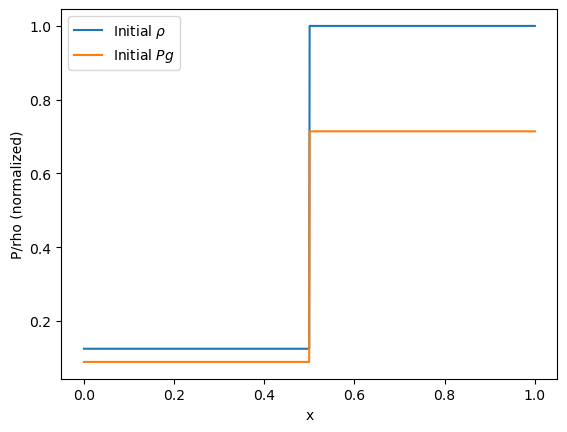

In [89]:
x = np.linspace(0, 1, 1024)
nt = 1000
idx = int(len(x)/2) # Index for setting the boarders 

gamma = 1.4 # 5/3
rho_L = 0.125
rho_R = 1.0
Pg_L  = 0.125/gamma
Pg_R  = 1.0/gamma

# Initialize the arrays 
rho0 = np.zeros((len(x)))
Pg0 = np.zeros((len(x)))
u = np.zeros((len(x)))
e0 = 0.5*rho0*u**2 + Pg0/(gamma-1)

# Set boarder 
rho0[:idx] = rho_L
rho0[idx:] = rho_R 
Pg0[:idx] = Pg_L
Pg0[idx:] = Pg_R

plt.plot(x, rho0[:], label=r"Initial $\rho$")
plt.plot(x, Pg0[:], label=r"Initial $Pg$")
plt.xlabel("x")
plt.ylabel("P/rho (normalized)")
plt.legend()
plt.show()
plt.close()

veloity should be 0 throughout 
p - 0.6 on right
density - hiher on the right 

In [90]:
# Evolve the discontinous numerical scheme 
t, rho_new, mom_new, e_new  = evol_hydro_euler(x, rho0, u, e0, Pg0, nt, gamma=1.4, axis=0, cfl_cut=0.48, 
                    ddx=nm.deriv_cent, bnd_type='wrap', bnd_limits=[0,0])

/tmp/ipykernel_4637/679532547.py:35: RuntimeWarning: divide by zero encountered in divide
  dt = cfl_cut*np.min(dx/np.abs(a))
/tmp/ipykernel_4637/679532547.py:55: RuntimeWarning: divide by zero encountered in divide
  dt = cfl_cut*np.min(dx/np.abs(a))
/tmp/ipykernel_4637/2810182783.py:64: RuntimeWarning: divide by zero encountered in divide
  dt1 = np.min(np.abs(dx/u))
/tmp/ipykernel_4637/679532547.py:45: RuntimeWarning: divide by zero encountered in divide
  dt = cfl_cut*np.min(dx/np.abs(a))
/tmp/ipykernel_4637/2810182783.py:67: RuntimeWarning: divide by zero encountered in divide
  dt2 = np.min(np.abs(dx/u_sound))


In [91]:
# FDC will be unstable, try lax -> it should look pretty ok (some oscillations)
# Bifrost is even better 

plt.ioff()

M = 10

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

def init(): 
    # normalize
    axes.plot(x, rho_new[:,0])
    # axes.plot(x, mom_new[:,0])
    # axes.plot(x, e_new[:,0])


def animate(i):
 
    axes.clear()
    axes.plot(x, rho_new[:,::M][:,i], label="density")
    # axes.plot(x, mom_new[:,::M][:,i], label="momentum")
    # axes.plot(x, e_new[:,::M][:,i], label="energy")
    axes.set_title('Discontinous parameters, t=%.12f'%t[::M][i])
    axes.set_xlabel("x")
    axes.set_ylabel("u_i")
    axes.set_xlim(0, 1)
    axes.legend()
    axes.grid()
    
    
anim = FuncAnimation(fig, animate, interval=50, frames=len(t[::M]), init_func=init)
HTML(anim.to_jshtml())

In [92]:
plt.close()

Note that by using the equation of state, $e = P_g/(\gamma - 1)\rho$, it is possible to compute the intial energy. 

## QUESTIONS: 


- How to initialize the Bifrost code? 
- Help with debugging the current code -> I think the timestep is off? 

- For the presentation, how can we present things? 

    Start with the hydro-codes, showing how Lax and Euler compare to Bifrost 

    Then make a gaussian fit and advance in time? 

    Plot the density, electro and pressure (these should diffuse a little)

Show how these change for the same timesteps. 

In [48]:
def gaussian(xx, A, mu, sigma, C): 
    """
    Gaussian function

    Parameters
    ----------
    xx : `array`
        Spatial axis. 
    A : `float`
        Amplitude. 
    mu : `float`
        Expected value. 
    sigma : `float`
        Standard deviation. 
    C : `int` or `float`
        Constant. 
    Returns 
    -------
    `array`
        Gaussian function
    """
    return A * np.exp(-0.5*(xx - mu)**2 / (sigma**2)) + C

# Using curve fit for the gaussian fit 
from scipy.optimize import curve_fit

# Initialize arrays for fitting
Amplitude = np.zeros(nt)
mu = np.zeros(nt)
sigma = np.zeros(nt)
C = np.zeros(nt)

for i in range(nt): 
    popt, pcov = curve_fit(gaussian, x, rho_new[:,i]) # optimal values, covariance matrix

    Amplitude[i] = popt[0]
    mu[i]        = popt[1]
    sigma[i]     = popt[2]
    C[i]         = popt[3]

ValueError: array must not contain infs or NaNs

## 3-  Add a new source terms: Thermal conduction (Semya)

Expand the HD equations by adding thermal conduction: 

$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = 0 $

$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u}  \otimes {\bf u}) = - \nabla (P_g)$

$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u} + \nabla \kappa \nabla T_g $

Use the ideal equation of state: 

$P_g = n K_B T_g$

where $n$ is the number of particles and assume everything is hydrogen. $K_B$ is the Boltzman constant. $\kappa$ is the thermal coefficient. 

Note that this term is diffusive. Which numerical scheme would you use to avoid stiffness? 

__Challenge__: Consider a Super-Time-Stepping method [See Ex_5](https://gitlab.com/ast5110_course/ast5110/-/blob/master/ex_5a.ipynb) and [see also Nobrega-Siverio et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...638A..79N/abstract)

### 3a- Test the code. 

Use the same asymptotical solutions to test the thermal conduction term as in [Ex_5](https://gitlab.com/ast5110_course/ast5110/-/blob/master/ex_5a.ipynb)
        
    

## notes 

New part in the energy equation. + kappa d2Tg/dx2


the energy equation will be very slow - consider tunning separatly 

## 4- (nano)-flares in the corona.  

Add an ad-hoc source term: 

$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = 0 $

$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u}  \otimes {\bf u}) = - \nabla (P_g)$

$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u} + \nabla \kappa \nabla T_g + S(x,t)$

where $S(x,t)$ is the ad-hoc source term which depend in space and time and it will have the follosing description: 

$S(x,t) = A \exp(-(x-x_0)^2/W_s^2) \exp(-(t-t_0)^2/W_t^2)$

where $A$ is the amplitud, $W_s$ the spatial width of the Gaussian centered at $x_0$, and $W_t$ the temporal range of the Gaussian centered at $t_0$. Consider different $W_s$ ranging from a few tens of km to a few Mm and $W_t$ ranging from a few fraction of second a 100s. 

For the initial condition: implement the same initial scenario as in [Heggland et al. 2007](https://iopscience.iop.org/article/10.1086/518828/pdf). Consider various density/temperature levels in the corona. 

One of the candidates to heat the corona is due to braiding of the magnetic field. Braiding can produce episodic (flaring) and localized heating in the solar atmosphere which is propagated along the magnetic field lines via thermal conduction or electron beans. The energy released on these flaring events can go from nano-flares to class X flares. Consider a 1D stratified atmosphere and invesgate the energy deposition along the 1D atmosphere for various background stratifications and energies for the flaring events. Where are you going to put the source? How does it travel? Compare with what we have learned from the assymptotic solution in [Ex_5](https://gitlab.com/ast5110_course/ast5110/-/blob/master/ex_5a.ipynb). Can you see evaporation? When? 

The parameter range is huge for this exercise ($W_s$, $W_t$, A, and initial conditions). Play with one thing at a time. No need to do all possible combinations. 

__Bonus__ consider a more irregular source in time: 

$S(x,t) = \sum_i^n A_i \exp(-(x-x_i)^2/W_{si}^2) \exp(-(t-t_i)^2/W_{ti}^2)$



### MY NOTES: 



## 3-  Add a new source terms: Nuclear reactions (Jakob Borg)

Expand the HD equations by a sink term that can destroy matter: 

$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = - S_\rho $

$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u}  \otimes {\bf u}) = - \nabla (P_g) - \rho {\bf u} S_\rho$

$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u} + \nabla \kappa \nabla T_g  - Q$

Use the ideal equation of state: 

$P_g = n K_B T_g$

where $n$ is the number of particles and assume everything is hydrogen. $K_B$ is the Boltzman constant. $\kappa$ is the thermal coefficient. 

Consider an $S$ that turns on after reaching certain density and temperature ($S(\rho,T)$) and growth exponentially with the product of both.

$Q$ is the energy losses. Looking at Gaute's exercise, how do you think this term would look like?

Note that this term is a source term and can be stiff. Which numerical scheme would you use to avoid stiffness? 

### 3a- Test the code. 

Start with a fix density and temperature above the lower limit. How does it evolve? 

## 4- gravity vs pressure and destroying mass.

Add a gravity that varies in z being max at the center and decreases as a gaussian. 

$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = - S_\rho $

$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u}  \otimes {\bf u}) = - \nabla (P_g) - \partial \rho {\bf u} S_\rho + g \rho$

$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u} + \nabla \kappa \nabla T_g  - Q$

Without the source. Consider constant density and let it run until reaches a steady state. 

Now turn on the sink source. 

# 3. External forces  (Johannes Midtbo)

Add an external force that will keep rotating the plasma.  

$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = 0 $

$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u}  \otimes {\bf u}) = - \nabla (P_g) - {\bf F(x,y)} + J \times B$

$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u} + \nabla \kappa \nabla T_g $

Test it without magnetic field first. 

# 4. global dynamo

Add constant magnetic field ($B(x)$) and let it run. Nature has many examples of global dynamo. In the sun, the differential rotation leads to a global dynamo that leads to the solar cycle. Accretion disk can experience similar effects. Investigate how the magnetic field changes. 

__bonus__ Consider to add a time component to the external force. 

## 3- Bifrost implementation. (Magne Elias Roland Udnaes) 

Implement the Bifrost 1D hydro scheme, i.e., 6th order spatial derivative and 5th order interpolation in a staggered mesh with the hyper-diffusive scheme. 

$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = 0 $

$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u} \otimes {\bf u}) + \tau_{vis}= - \nabla (P_g)$

$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u} + \mu (\nabla{\bf u})^2 + Q_\tau$

Make sure that the diffused term goes into the energy equation. How it will look like?

### 3- Viscousity. (TBD) 

While most of the time the numerical resolutions are not high enough to reproduce the Reynolds number within the solar atmosphere, it is also true that the chromosphere can have large dissipative effects comming from ion-neutral interactions. To mimic that effect we will introduce a new viscouse term in the momentum and energy equations as follows: 

$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = 0 $

$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u} \otimes {\bf u}) + \nabla \mu \nabla{\bf u}= - \nabla (P_g)$

$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u} + \mu (\nabla{\bf u})^2$

where $\mu$ is the viscouse coeficient and has units of g/cm/s. The viscosity can be also express as a kinematic viscosity as follow $\nu = \mu/\rho $ in units of $cm^2/s$. It will depend on the type of fluids, collisions, temperature and densities. In the chromosphere, one of the dominant diffusive therm is the ambipolar diffusion which comes from the ion-neutral interactions. We are not solving here the magnetic field evolution nor two fluids, but lets assume that the dissipation acts as a viscouse. The kinematic viscosity ($\nu$) ranges from $10^6-10^{12}$ m$^2$/s. This can be found for instance in the numerical models [Martinez-Sykora et al. 2019](https://iopscience.iop.org/article/10.3847/1538-4357/ab643f). These models included ambipolar diffusion and non-equilibrium ionization which changed drasticaly the diffusive term within the atmosphere. Use this range to parametrize how shocks could be dissipated within the chromosphere. 

__bonus__ [Martinez-Sykora et al. 2019](https://iopscience.iop.org/article/10.3847/1538-4357/ab643f/pdf) provides fits files with the diffusions in tables that depend on temperature and density, i.e., $\nu(\rho,T)$ is a tabulated function. Consider to add that possiblity and compare with a fix value. 

### 3a- Viscousity. (both) 

Consider a random perturbation in density and velocity. Calculate k-diagrams. Which spatial scales gets dissipated? Why? What happens when there is a constant velocity. Try for different speeds. 

## 4- Parameter range

Waves in the solar chromosphere comes with many fequencies and amplitudes. From a stratified atmosphere such as the one in [Heggland et al. 2007](https://iopscience.iop.org/article/10.1086/518828/pdf) you will investigate how shocks travel in the chromosphere and transition region. For this, following this reference, drive the bottom boundary with acoustic waves at different frequencies and amplitudes. Can you recognice the different features as the sod-shock test? 

### 4a- Frequency.

How does change the chromospheric thermo-dynamic properties for a fix amplitude the frequency of the driven waves. 
Go from high frequencies (0.1Hz) to 5 minutes oscilations. This parameter range have been observed [Okamoto et al. 2011](https://iopscience.iop.org/article/10.1088/2041-8205/736/2/L24). However, those waves were Alfvenic waves instead of magnetic acoustic shocks as done here.  

What is the role of the viscosity to the shock traveling through the chromosphere? 


### 4b- Amplitud.

How does change the chromospheric thermo-dynamic properties for a fix frequency and various amplitudes of the driven waves. Use the same parameter range as in [Heggland et al. 2007](https://iopscience.iop.org/article/10.1086/518828/pdf). 

What is the role of the viscosity to the shock traveling through the chromosphere? 

### 4c- Bonnus, try to add a _white_ driven random waves. 

The idea here is to see which frequencies goes through when the source can produce various types of waves. Use a powerlaw of frequency and energy. 

## 3-  Two system of equations: two fluids (Gaute Amesson Holen). 

The chromosphere, transition region and corona are weakly collisional. Therefore, different fluids or species can experience different forces and consequently drift with other fluids. As a result, under these conditions, single fluid equations are not accurate enough. The presence of velocity drift between fluids could be eventually dissipate and heat the plasma. 

Duplicate the HD equations and couple them with the momentum and energy exchange as follows: 

$ \frac{\partial \rho_\alpha}{\partial t} + \nabla \cdot (\rho_\alpha \bf u_\alpha) = 0 $

$ \frac{\partial \rho_\alpha {\bf u_\alpha}}{\partial t} + \nabla \cdot (\rho_\alpha {\bf u_\alpha} \otimes {\bf u_\alpha}) = - \nabla (P_{g\alpha}) + \rho_\alpha \nu_{\alpha\beta}(u_\alpha-u_\beta)$

$ \frac{\partial e_\alpha}{\partial t } = -\nabla\cdot e_\alpha {\bf u_\alpha} -P_{g\alpha} \nabla \cdot {\bf u_\alpha} + Q_{\alpha}^{\alpha\beta}$

where $\alpha= [i,n]$ and $\beta$ refer either to ions $i$ or neutrals $n$. For simplicity, lets assume hydrogen and protons and consider to impose a fix collision frequency. Due to conservation $\rho_\alpha \nu_{\alpha\beta}=\rho_\beta \nu_{\beta\alpha}$. 


$Q_{\alpha}^{\alpha\beta} = \frac{n_{\alpha} m_{\alpha} \nu_{\alpha \beta}}{m_{\alpha}+m_{\beta}} \left[m_{\beta}(\vec{u}_\beta - \vec{u}_\alpha)^2+\frac{2 k_B}{\gamma-1} \left(T_{\beta}-T_{\alpha}\right)\right]$

where $m_{\alpha\beta} = \frac{m_{\alpha}m_{\beta}}{m_{\alpha}+m_{\beta}}$, and for this exercise, since we assume only hydrogen, $m_\alpha \approx m_\beta$ is a good proxy. 

For further description of multicomponent fluids see e.g. the book by [Zhdanov 2002](https://ui.adsabs.harvard.edu/abs/2002PPCF...44.2283Z/abstract), [Khomenko et al 2014](https://ui.adsabs.harvard.edu/abs/2014PhPl...21i2901K/abstract). 


#### 3a- Test the code: 

Consider the following tests to validate the implementation: 

    1) Consider an scenario with no heating sources and constant collision frequency. In that case, it is simple to compute the slope in loglog scale of the velocity drift. 
        1a) What would happen in you turn $Q^{\alpha\beta}_\alpha$ on? 
    2) Assuming zero velocity drift, what would be the temperature evolution when the two fluids are different?     

### 4- Energy dissipated in the chromosphere. 

Ion-neutral interaction cans play a big role on dissipating the magnetic energy. The figure below reveals the collision frequency parameter range within the chromosphere. A zero order of the velocity drift can be found in [Martinez-Sykora et al 2016](https://iopscience.iop.org/article/10.3847/2041-8205/831/1/L1/pdf) Fig. 4b. Use the numerical code to provide a better understanding on the time-scale of the heating and damping mechanism within the chromosphere. 

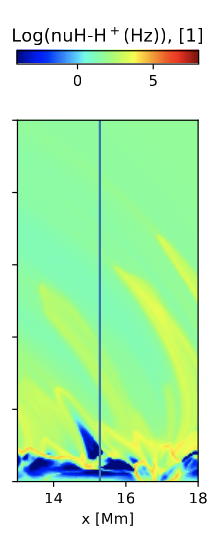

__bonus__ One can compute the collision frequency as follows: 

$\nu^{\text{col,L}}_{\alpha, \beta}=\frac{m_{\alpha,\beta}}{m_{\beta}} n_{\beta} u^{th}_{\alpha,\beta}\, \sigma_{\alpha,\beta}\left(T_{\alpha,\beta}\right)$

where $T_{\alpha,\beta} =(m_{\alpha} T_{\alpha}+m_{\beta} T_{\beta} )/(m_{\alpha}+m_{\beta})$ is the weigthed temperature, $u^{th}_{\alpha,\beta} = |\sqrt{\frac{8}{\pi\mu_{\alpha,\beta}}}|$ is the thermal velocity with $\mu_{\alpha,\beta} = \frac{\mu_{\alpha}\,\mu_{\beta}}{\mu_{\alpha}+\mu_{\beta}}$ and $\mu_{\alpha} = \frac{m_\alpha}{K_B T_\alpha}$. $K_B$ is the Boltzmann constant. The cross-section ($\sigma_{\alpha,\beta}(\left(T_{\alpha,\beta}\right)$) are tabulated as a function of temperature and for this exersize you can use the one from [Bruno et al. 2010](https://aip.scitation.org/doi/10.1063/1.3495980). Ask me for the table. 

## 3-  2D models (Aline & Camilla -- turbulence) 

Expand the following equations into a two (or three) dimensions. In order to facilitate the implementation, consider step 1 and 2 already in 3D. So, the variables are 3D (nx,ny,nz). In that case, in 1D, the variables are still 3D, i.e., (nx, 1, 1). Where the derivatives out of the domain are zero, i.e., $\frac{\partial \rho}{\partial z} = 0$

$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = 0 $

$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u} \otimes {\bf u}) = - \nabla (P_g)$

$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u}$

Consider to implement Bifrost numerical scheme (derivations, interpolations and hyper diffusive term). To clarify the diadic and tensorial product as well as the multi-dimensions. The momentum conservation becomes into 2 (in 2D) or 3 (in 2.5D or 3D) equations, i.e., for the x, y and/or z components. The following operation $\nabla \cdot (\rho {\bf u} \otimes {\bf u})$  can be expanded as follows for the x, y and z components: 

$\frac {\partial \rho u_x^2}{\partial x} + \frac {\partial \rho u_x u_y}{\partial y} + \frac {\partial \rho u_x u_z}{\partial z}$

$\frac {\partial \rho u_y^2}{\partial y} + \frac {\partial \rho u_x u_y}{\partial x} + \frac {\partial \rho u_y u_z}{\partial z}$

$\frac {\partial \rho u_z^2}{\partial z} + \frac {\partial \rho u_z u_y}{\partial y} + \frac {\partial \rho u_x u_z}{\partial x}$

which comes from the following matrix operations: 

$
\nabla \cdot (\rho {\mathbf{u} \otimes \mathbf{u}})=\left[\begin{array}{c}
\frac{\partial}{\partial x} \\
\frac{\partial}{\partial y} \\
\frac{\partial}{\partial z}
\end{array}\right]
\left(\rho
\left[\begin{array}{cccc}
u_{x} u_{x} & u_{x} u_{y} & u_{x} u_{z} \\
u_{y} u_{x} & u_{y} u_{y} & u_{y} u_{z} \\
u_{z} u_{x} & u_{z} u_{y} & u_{z} u_{z}
\end{array}\right]\right)
$


### 3a- Test the code: 

For simplicity, consider a 2D gaussian profile in density which is pressure balance and with an initial velocity (like for 1D case).  I recommend that the initial velocity is diagonal. 

__bonus__ you can also add other test that are described here [Flash code hydro tests](http://flash.uchicago.edu/site/flashcode/user_support/flash_ug_devel/node184.html#SECTION010115000000000000000). From that list, good options are Blast, Sedov explosion, Isentropic Vortex, or Relativistic Two-dimensional Riemann (but not relativistic). 

## 4- "chromospheric"-coronal transitions: Prominences and spicules 

### 4.1- Kelvin-Helmhotz instability in Spicules
Kelvin-Helmhotz instability: Spicules are highly dynamic cold dens material traveling into the million degrees corona. Investigate the shear, vortices, scales, and mixing with the following initial setup. Devide the domain with background environmetal properties, 1) typical from quiet corona (i.e., 1 million K degrees and densities of $10^{-14}$ g/cm$^3$) and zero velocity 2) typical from the upper-chromosphere (i.e., 8,000 K degrees and densities of $10^{-12}$ g/cm$^3$) with 100km/s [Chintzoglou et al. 2021](https://iopscience.iop.org/article/10.3847/1538-4357/abc9b1). One could consider periodic boundary conditions if the middle of the domain is the upper chromosphere, and top and bottom corona.

### 4.2- Rayleigh-Taylor instability in Prominences
Rayleigh-Taylor instability: Solar Prominences are cold dens material embebed in the million degrees corona. Add gravity to the HD eq. Using the same setup but the chromospheric material will be above the corona, both with zero velocity. Investigate the vortices, scales, and mixing. In this case, one needs to have constant extrapolation at the top and bottom where the top is the prominence and the bottom the corona.

Investigate with different numerical domains and resolutions in both setups.

## 3- 1.5D Magnetic field (Tor-Andreas)

The convective motion shakes the magnetic field driving Alfven waves. The wave power is enough to drive the solar wind. However, it is unclear how this wave power is transfered and deposited into the corona. Expand the 1D HD code to an 1.5D MHD code as follows: 

$ \frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \bf u) = 0 $

$ \frac{\partial \rho {\bf u}}{\partial t} + \nabla \cdot (\rho {\bf u} \otimes {\bf u}) = - \nabla (P_g) + {\bf J}\times {\bf B}$

$ \frac{\partial e}{\partial t } = -\nabla\cdot e {\bf u} -P_g \nabla \cdot {\bf u}$

where ${\bf J} = \nabla \times {\bf B}$. It is important to have all three components for ${\bf u}$ and ${\bf B}$, so you need to solve the momentum equation for all three components. This is known as 1.5Dimensions. On top of this, now we need to solve the evolution of the magnetic field. For this we will solve the induction equations as follows: 

$ \frac{\partial {\bf B}}{\partial t } = - \nabla ({\bf u}\times{\bf B}) $

To expand the advection term in 1.5D (see Killian's description too). You need to expand the momentum equation for the various components of the momentum. However, since its in 1D, the $\partial /\partial y$ and $\partial / \partial z$ are zeros because the axis perpendicular to the 1D domain are assumed constant in space. So, taking that into account, the following operation $\nabla \cdot (\rho {\bf u} \otimes {\bf u})$  can be expanded as follows for the x, y and z components: 

$\frac {\partial \rho u_x^2}{\partial x} $

$\frac {\partial \rho u_x u_y}{\partial x}$

$\frac {\partial \rho u_x u_z}{\partial x}$

which comes from the following matrix operations: 

$
\nabla \cdot (\rho {\mathbf{u} \otimes \mathbf{u}})=\left[\begin{array}{c}
\frac{\partial}{\partial x} \\
\frac{\partial}{\partial y} \\
\frac{\partial}{\partial z}
\end{array}\right]
\left(\rho
\left[\begin{array}{cccc}
u_{x} u_{x} & u_{x} u_{y} & u_{x} u_{z} \\
u_{y} u_{x} & u_{y} u_{y} & u_{y} u_{z} \\
u_{z} u_{x} & u_{z} u_{y} & u_{z} u_{z}
\end{array}\right]\right)
$

and we assumed, as mentioned, $\partial /\partial y$ and $\partial / \partial z$ are zeros. 

## 4- Alfven waves
Go from high frequencies (0.1Hz) to 5 minutes oscilations. This parameter range have been observed [Okamoto et al. 2011](https://iopscience.iop.org/article/10.1088/2041-8205/736/2/L24). How this energy propagates through the atmosphere? Do waves in 1D constant atmosphere, i.e., no gravity nor stratification. Put an initial wave and see how long it takes to dissipate for various frequencies due to the artificial diffusion. 


__bonus__ Add gravity and prepare a stratified atmosphere. Drive the 1D amtosphere with Alfven waves (changing the magnetic field at the boundaries). How does these wave propagate? 